# 1 (a) FNN model architecture

In [ ]:
import json
import argparse
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


def plot_result(config, train_loss_record, test_loss_record, train_acc, test_acc):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6.4*2, 4.8))
    axes = axes.flatten()

    axes[0].set_title('Average Loss')
    axes[0].set_xlabel('Iterations')
    axes[0].set_ylabel('Cross-entropy Loss')
    axes[0].plot(train_loss_record, label='Training')
    axes[0].plot(test_loss_record, label='Testing')
    axes[0].legend()

    axes[1].set_title('Total Accuracy')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Accuracy')
    axes[1].plot(train_acc, label='Training')
    axes[1].plot(test_acc, label='Testing')
    axes[1].legend()

    plt.show()

    return


class DNN():
    def __init__(self, config, init_weight, weight=None):
        self.config = config
        self.weights, self.bias = self.initial_weight(init_weight=init_weight, weight=weight)
        self.backward_1 = []  # 存w*x+b, index為0~3
        self.backward_2 = []  # 存activation(w*x+b), index為0~3
        self.dw = []
        self.db = []

    def initial_weight(self, init_weight, weight):
        '''
            weights[0] : (784, 2048), bias[0] : (2048,)
            weights[1] : (2048, 512), bias[1] : (512,)
            weights[2] : (512, 5), bias[2] : (5,)
        '''

        weights = []
        bias = []
        if init_weight == 'npy':
            for i in weight['w']:
                weights.append(i)
            for i in weight['b']:
                bias.append(i)

        elif init_weight == 'zero':
            for key, value in self.config.items():
                weights.append(np.zeros((value.get('input_dim'), value.get('output_dim'))))
                bias.append(np.zeros(value.get('output_dim'), ))

        return weights, bias

    def activation(self, x, func, deriv=False):
        '''
            x : (output_dim, batch_size)
        '''

        if func == 'relu':
            if deriv:
                return np.greater(x, 0).astype(int)
            else:
                return x * (x > 0)

        elif func == 'softmax':
            y = np.exp(x - np.max(x, axis=0)) / np.sum(np.exp(x - np.max(x, axis=0)), axis=0, keepdims=False)
            if deriv:
                return y * (1 - y)
            else:
                return y

    def criterion(self, y, t, deriv=False):

        # Cross-entropy loss
        if deriv:
            return y - t
        else:
            return - np.sum(t * np.log(y + 0.001)) / len(y)

    def forward(self, x):
        '''
            x : (batch_size, input_dim) -> (batch_size, 784)
        '''

        # Reshape x to (input_size, batch_size) -> column vector for each data
        self.backward_1.append(x.T)  # (784, 200)  # 存w*x+b
        self.backward_2.append(x.T)  # (784, 200)  # 存activation(w*x+b)

        for idx, w in enumerate(self.weights):

            # Forward pass : w*x+b
            backward_1 = np.dot(w.T, self.backward_2[-1])  # (2048, 784) @ (784, batch_size) = (2048, batch_size)
            for i in range(len(backward_1.T)):
                backward_1[:, i] += self.bias[idx]

            # 過activation
            if idx == len(self.weights) - 1:
                # Output layer
                backward_2 = self.activation(backward_1, 'softmax')
            else:
                # Hidden layer
                backward_2 = self.activation(backward_1, 'relu')

            # Save the output of each layer for backward pass
            self.backward_1.append(backward_1)
            self.backward_2.append(backward_2)

        # Reshape from (output_dim, batch_size) to (batch_size, output_dim)
        # a[-1]   : (6, batch_size)
        # a[-1].T : (batch_size, 6)
        output = self.backward_2[-1].T  # 回傳activation(w*x+b)

        return output

    def backward(self, output, t):
        for k in range(len(self.weights), 0, -1):

            if k == len(self.weights):
                error_w = (self.backward_2[-1].T - t)  # 對cross-entropy以及softmax的微分結果
                error_b = np.zeros(len(error_w.T), )  # (5, )
                for i in range(len(error_w)):
                    error_b[:, ] += error_w[i].T
                self.dw.insert(0, np.dot(self.backward_2[k-1], error_w))
                self.db.insert(0, error_b)
            else:
                error_w = np.dot(error_w, self.weights[k].T) * self.activation(self.backward_1[k], func='relu', deriv=True).T
                error_b = np.zeros(len(error_w.T), )  # (512, )
                for i in range(len(error_w)):
                    error_b[:, ] += error_w[i].T

                self.dw.insert(0, np.dot(self.backward_2[k-1], error_w))
                self.db.insert(0, error_b)

        return self.dw, self.db


def run(model, config, X_train, Y_train, X_test, Y_test):

    log_interval = 10

    training_epochs = 20
    learning_rate = 0.001
    training_batch_size = 200
    num_of_training_batch = math.ceil(X_train.shape[0] / training_batch_size)

    testing_log_interval = 50
    training_epochs = 20
    learning_rate = 0.001
    testing_batch_size = 200
    num_of_testing_batch = math.ceil(X_test.shape[0] / testing_batch_size)

    train_loss_record = []
    test_loss_record = []

    tolal_training_correct = []
    tolal_testing_correct = []
    iters = 0

    for epoch in range(training_epochs):
        # Training
        for batch_idx in range(num_of_training_batch):
            model.backward_1 = []
            model.backward_2 = []

            trainging_correct = 0

            if batch_idx == num_of_training_batch - 1:
                x_train = X_train[batch_idx*training_batch_size:, :]
                y_train = Y_train[batch_idx*training_batch_size:, :]
            else:
                x_train = X_train[batch_idx*training_batch_size:(batch_idx+1)*training_batch_size, :]
                y_train = Y_train[batch_idx*training_batch_size:(batch_idx+1)*training_batch_size, :]

            # Forward pass
            output = model.forward(x_train)
            loss = model.criterion(output, y_train)
            pred = np.argmax(output, axis=-1)
            y_train_ = np.argmax(y_train, axis=-1)
            trainging_correct += (pred == y_train_).sum()

            # Backforward pass
            model.dw = []
            model.db = []
            model.backward(output, y_train)

            # Update model weights
            for i in range(len(model.weights)):
                model.weights[i] -= learning_rate * model.dw[i] / len(x_train)
                model.bias[i] -= learning_rate * model.db[i] / len(x_train)

            # Print the info of training
            if (batch_idx+1) % log_interval == 0:
                if len(x_train) != training_batch_size:
                    print(f'Epoch: [{training_epochs+1}/{training_epochs}] | Step: [{len(X_train)}/{len(X_train)} ({100.*(batch_idx+1)/training_batch_size:.0f}%)]', end=' ')
                else:
                    print(f'Epoch: [{epoch+1}/{training_epochs}] | Step: [{(batch_idx+1)*len(x_train)}/{len(X_train)} ({100.*(batch_idx+1)/num_of_training_batch:.0f}%)]', end=' ')
                print(f'| Loss: {loss:.6f} | Acc: [{trainging_correct}/{len(x_train)} ({100.*trainging_correct/len(x_train):.2f}%)] ')

            train_loss_record.append(loss)
            tolal_training_correct.append(trainging_correct / training_batch_size)

            total_test_loss = 0.0

            # Testing
            for test_batch_idx in range(num_of_testing_batch):
                model.backward_1 = []
                model.backward_2 = []

                testing_correct = 0

                if test_batch_idx == num_of_testing_batch - 1:
                    x_test = X_test[test_batch_idx*testing_batch_size:, :]
                    y_test = Y_test[test_batch_idx*testing_batch_size:, :]
                else:
                    x_test = X_test[test_batch_idx*testing_batch_size:(test_batch_idx+1)*testing_batch_size, :]
                    y_test = Y_test[test_batch_idx*testing_batch_size:(test_batch_idx+1)*testing_batch_size, :]

                # Forward pass
                output = model.forward(x_test)  # (batch_size, output_dim)

                loss = model.criterion(output, y_test)
                total_test_loss += loss

                pred = np.argmax(output, axis=-1)
                y_test_ = np.argmax(y_test, axis=-1)
                testing_correct += (pred == y_test_).sum()

            if (batch_idx+1) % log_interval == 0:
                print('-' * 25)
                print('Testing accuracy: {}/{} ({:.2f}%)'.format(testing_correct, testing_batch_size, 100. * testing_correct / testing_batch_size))
            if (batch_idx+1) % log_interval == 0:
                pass

            test_loss_record.append(loss / len(X_test))
            tolal_testing_correct.append(testing_correct / testing_batch_size)

        print('-' * 50)

    return train_loss_record, test_loss_record, tolal_training_correct, tolal_testing_correct

model_config = {
        "layer1": {
            "input_dim": 784,
            "output_dim": 2048,
            "activation": "relu"
        },
        "layer2": {
            "input_dim": 2048,
            "output_dim": 512,
            "activation": "relu"
        },
        "output": {
            "input_dim": 512,
            "output_dim": 5,
            "activation": "softmax"
        }
    }


In [ ]:
train_x, train_y = np.load('./fashion_mnist/train_x.npy'), np.load('./fashion_mnist/train_y.npy')
test_x, test_y = np.load('./fashion_mnist/test_x.npy'), np.load('./fashion_mnist/test_y.npy')

# Normalize
train_x = train_x / 255.
test_x = test_x / 255.

# Convert target to one-hot encoding
num_of_class = train_y.max() + 1
train_y = np.eye(num_of_class, dtype=np.int32)[train_y]
test_y = np.eye(num_of_class, dtype=np.int32)[test_y]

checkpoint = np.load('./weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

model = DNN(config=model_config, init_weight='npy', weight=checkpoint)

train_loss_log = []
test_loss_log = []
train_acc_log = []
test_acc_log = []

train_loss_record, test_loss_record, tolal_training_correct, tolal_testing_correct = run(model, config, train_x, train_y, test_x, test_y)


Epoch: [1/20] | Step: [2000/30000 (7%)] | Loss: 0.896117 | Acc: [174/200 (87.00%)] 
-------------------------
Testing accuracy: 178/200 (89.00%)
Epoch: [1/20] | Step: [4000/30000 (13%)] | Loss: 0.448070 | Acc: [187/200 (93.50%)] 
-------------------------
Testing accuracy: 184/200 (92.00%)
Epoch: [1/20] | Step: [6000/30000 (20%)] | Loss: 0.551699 | Acc: [184/200 (92.00%)] 
-------------------------
Testing accuracy: 184/200 (92.00%)
Epoch: [1/20] | Step: [8000/30000 (27%)] | Loss: 0.551701 | Acc: [184/200 (92.00%)] 
-------------------------
Testing accuracy: 185/200 (92.50%)
Epoch: [1/20] | Step: [10000/30000 (33%)] | Loss: 0.586245 | Acc: [183/200 (91.50%)] 
-------------------------
Testing accuracy: 187/200 (93.50%)
Epoch: [1/20] | Step: [12000/30000 (40%)] | Loss: 0.275351 | Acc: [192/200 (96.00%)] 
-------------------------
Testing accuracy: 188/200 (94.00%)
Epoch: [1/20] | Step: [14000/30000 (47%)] | Loss: 0.206263 | Acc: [194/200 (97.00%)] 
-------------------------
Testing acc

Epoch: [4/20] | Step: [22000/30000 (73%)] | Loss: 0.240807 | Acc: [193/200 (96.50%)] 
-------------------------
Testing accuracy: 192/200 (96.00%)
Epoch: [4/20] | Step: [24000/30000 (80%)] | Loss: 0.137176 | Acc: [196/200 (98.00%)] 
-------------------------
Testing accuracy: 193/200 (96.50%)
Epoch: [4/20] | Step: [26000/30000 (87%)] | Loss: 0.171719 | Acc: [195/200 (97.50%)] 
-------------------------
Testing accuracy: 193/200 (96.50%)
Epoch: [4/20] | Step: [28000/30000 (93%)] | Loss: 0.137370 | Acc: [196/200 (98.00%)] 
-------------------------
Testing accuracy: 194/200 (97.00%)
Epoch: [4/20] | Step: [30000/30000 (100%)] | Loss: 0.068088 | Acc: [198/200 (99.00%)] 
-------------------------
Testing accuracy: 193/200 (96.50%)
--------------------------------------------------
Epoch: [5/20] | Step: [2000/30000 (7%)] | Loss: 0.102632 | Acc: [197/200 (98.50%)] 
-------------------------
Testing accuracy: 193/200 (96.50%)
Epoch: [5/20] | Step: [4000/30000 (13%)] | Loss: 0.102632 | Acc: [19

-------------------------
Testing accuracy: 194/200 (97.00%)
Epoch: [8/20] | Step: [12000/30000 (40%)] | Loss: 0.102632 | Acc: [197/200 (98.50%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [8/20] | Step: [14000/30000 (47%)] | Loss: 0.053908 | Acc: [198/200 (99.00%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [8/20] | Step: [16000/30000 (53%)] | Loss: 0.033544 | Acc: [199/200 (99.50%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [8/20] | Step: [18000/30000 (60%)] | Loss: 0.137176 | Acc: [196/200 (98.00%)] 
-------------------------
Testing accuracy: 196/200 (98.00%)
Epoch: [8/20] | Step: [20000/30000 (67%)] | Loss: 0.137176 | Acc: [196/200 (98.00%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [8/20] | Step: [22000/30000 (73%)] | Loss: 0.206263 | Acc: [194/200 (97.00%)] 
-------------------------
Testing accuracy: 194/200 (97.00%)
Epoch: [8/20] | Step: [24000/30000 (80%)] | Loss: 0.10263

-------------------------
Testing accuracy: 196/200 (98.00%)
--------------------------------------------------
Epoch: [12/20] | Step: [2000/30000 (7%)] | Loss: 0.102632 | Acc: [197/200 (98.50%)] 
-------------------------
Testing accuracy: 194/200 (97.00%)
Epoch: [12/20] | Step: [4000/30000 (13%)] | Loss: -0.001000 | Acc: [200/200 (100.00%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [12/20] | Step: [6000/30000 (20%)] | Loss: 0.072034 | Acc: [197/200 (98.50%)] 
-------------------------
Testing accuracy: 196/200 (98.00%)
Epoch: [12/20] | Step: [8000/30000 (27%)] | Loss: 0.171719 | Acc: [195/200 (97.50%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [12/20] | Step: [10000/30000 (33%)] | Loss: 0.068088 | Acc: [198/200 (99.00%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [12/20] | Step: [12000/30000 (40%)] | Loss: 0.068088 | Acc: [198/200 (99.00%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epo

Epoch: [15/20] | Step: [20000/30000 (67%)] | Loss: 0.171719 | Acc: [195/200 (97.50%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [15/20] | Step: [22000/30000 (73%)] | Loss: 0.033544 | Acc: [199/200 (99.50%)] 
-------------------------
Testing accuracy: 196/200 (98.00%)
Epoch: [15/20] | Step: [24000/30000 (80%)] | Loss: 0.094666 | Acc: [197/200 (98.50%)] 
-------------------------
Testing accuracy: 196/200 (98.00%)
Epoch: [15/20] | Step: [26000/30000 (87%)] | Loss: 0.068088 | Acc: [198/200 (99.00%)] 
-------------------------
Testing accuracy: 196/200 (98.00%)
Epoch: [15/20] | Step: [28000/30000 (93%)] | Loss: 0.033544 | Acc: [199/200 (99.50%)] 
-------------------------
Testing accuracy: 196/200 (98.00%)
Epoch: [15/20] | Step: [30000/30000 (100%)] | Loss: 0.033544 | Acc: [199/200 (99.50%)] 
-------------------------
Testing accuracy: 196/200 (98.00%)
--------------------------------------------------
Epoch: [16/20] | Step: [2000/30000 (7%)] | Loss: 0.102632 | 

Epoch: [19/20] | Step: [8000/30000 (27%)] | Loss: 0.102632 | Acc: [197/200 (98.50%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [19/20] | Step: [10000/30000 (33%)] | Loss: 0.068088 | Acc: [198/200 (99.00%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [19/20] | Step: [12000/30000 (40%)] | Loss: 0.102632 | Acc: [197/200 (98.50%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [19/20] | Step: [14000/30000 (47%)] | Loss: 0.033544 | Acc: [199/200 (99.50%)] 
-------------------------
Testing accuracy: 194/200 (97.00%)
Epoch: [19/20] | Step: [16000/30000 (53%)] | Loss: 0.033544 | Acc: [199/200 (99.50%)] 
-------------------------
Testing accuracy: 196/200 (98.00%)
Epoch: [19/20] | Step: [18000/30000 (60%)] | Loss: 0.102632 | Acc: [197/200 (98.50%)] 
-------------------------
Testing accuracy: 195/200 (97.50%)
Epoch: [19/20] | Step: [20000/30000 (67%)] | Loss: 0.102624 | Acc: [197/200 (98.50%)] 
-------------------------


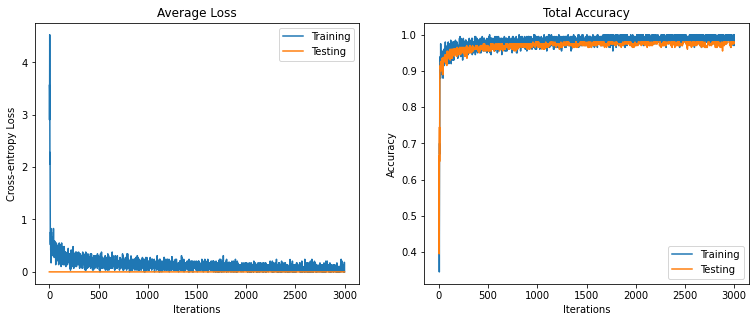

In [ ]:
plot_result(config, train_loss_record, test_loss_record, tolal_training_correct, tolal_testing_correct)

# 1 (b) Repeat 1(a) by considering zero initialization for the model weights. And do some discussion

In [ ]:
train_x, train_y = np.load('./fashion_mnist/train_x.npy'), np.load('./fashion_mnist/train_y.npy')
test_x, test_y = np.load('./fashion_mnist/test_x.npy'), np.load('./fashion_mnist/test_y.npy')

# Normalize
train_x = train_x / 255.
test_x = test_x / 255.

# Convert target to one-hot encoding
num_of_class = train_y.max() + 1
train_y = np.eye(num_of_class, dtype=np.int32)[train_y]
test_y = np.eye(num_of_class, dtype=np.int32)[test_y]

checkpoint = np.load('./weights.npy', allow_pickle=True).item()
init_weights = checkpoint['w']
init_biases = checkpoint['b']

# DNN with zero initialization for model weights
model = DNN(config=model_config, init_weight='zero', weight=checkpoint)

train_loss_log = []
test_loss_log = []
train_acc_log = []
test_acc_log = []

train_loss_record, test_loss_record, tolal_training_correct, tolal_testing_correct = run(model, config, train_x, train_y, test_x, test_y)


Epoch: [1/20] | Step: [2000/30000 (7%)] | Loss: 1.604449 | Acc: [48/200 (24.00%)] 
-------------------------
Testing accuracy: 47/200 (23.50%)
Epoch: [1/20] | Step: [4000/30000 (13%)] | Loss: 1.604443 | Acc: [39/200 (19.50%)] 
-------------------------
Testing accuracy: 47/200 (23.50%)
Epoch: [1/20] | Step: [6000/30000 (20%)] | Loss: 1.604462 | Acc: [38/200 (19.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [1/20] | Step: [8000/30000 (27%)] | Loss: 1.604429 | Acc: [54/200 (27.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [1/20] | Step: [10000/30000 (33%)] | Loss: 1.604456 | Acc: [38/200 (19.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [1/20] | Step: [12000/30000 (40%)] | Loss: 1.604470 | Acc: [30/200 (15.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [1/20] | Step: [14000/30000 (47%)] | Loss: 1.604441 | Acc: [44/200 (22.00%)] 
-------------------------
Testing accuracy: 39/200

-------------------------
Testing accuracy: 39/200 (19.50%)
Epoch: [4/20] | Step: [24000/30000 (80%)] | Loss: 1.604463 | Acc: [33/200 (16.50%)] 
-------------------------
Testing accuracy: 37/200 (18.50%)
Epoch: [4/20] | Step: [26000/30000 (87%)] | Loss: 1.604447 | Acc: [42/200 (21.00%)] 
-------------------------
Testing accuracy: 37/200 (18.50%)
Epoch: [4/20] | Step: [28000/30000 (93%)] | Loss: 1.604453 | Acc: [36/200 (18.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [4/20] | Step: [30000/30000 (100%)] | Loss: 1.604456 | Acc: [29/200 (14.50%)] 
-------------------------
Testing accuracy: 35/200 (17.50%)
--------------------------------------------------
Epoch: [5/20] | Step: [2000/30000 (7%)] | Loss: 1.604449 | Acc: [48/200 (24.00%)] 
-------------------------
Testing accuracy: 47/200 (23.50%)
Epoch: [5/20] | Step: [4000/30000 (13%)] | Loss: 1.604444 | Acc: [39/200 (19.50%)] 
-------------------------
Testing accuracy: 47/200 (23.50%)
Epoch: [5/20] | Step:

Epoch: [8/20] | Step: [14000/30000 (47%)] | Loss: 1.604442 | Acc: [45/200 (22.50%)] 
-------------------------
Testing accuracy: 39/200 (19.50%)
Epoch: [8/20] | Step: [16000/30000 (53%)] | Loss: 1.604446 | Acc: [40/200 (20.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [8/20] | Step: [18000/30000 (60%)] | Loss: 1.604466 | Acc: [33/200 (16.50%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [8/20] | Step: [20000/30000 (67%)] | Loss: 1.604455 | Acc: [29/200 (14.50%)] 
-------------------------
Testing accuracy: 39/200 (19.50%)
Epoch: [8/20] | Step: [22000/30000 (73%)] | Loss: 1.604453 | Acc: [28/200 (14.00%)] 
-------------------------
Testing accuracy: 39/200 (19.50%)
Epoch: [8/20] | Step: [24000/30000 (80%)] | Loss: 1.604462 | Acc: [33/200 (16.50%)] 
-------------------------
Testing accuracy: 37/200 (18.50%)
Epoch: [8/20] | Step: [26000/30000 (87%)] | Loss: 1.604445 | Acc: [42/200 (21.00%)] 
-------------------------
Testing accuracy: 3

Epoch: [12/20] | Step: [4000/30000 (13%)] | Loss: 1.604445 | Acc: [39/200 (19.50%)] 
-------------------------
Testing accuracy: 47/200 (23.50%)
Epoch: [12/20] | Step: [6000/30000 (20%)] | Loss: 1.604463 | Acc: [38/200 (19.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [12/20] | Step: [8000/30000 (27%)] | Loss: 1.604431 | Acc: [54/200 (27.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [12/20] | Step: [10000/30000 (33%)] | Loss: 1.604457 | Acc: [38/200 (19.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [12/20] | Step: [12000/30000 (40%)] | Loss: 1.604467 | Acc: [30/200 (15.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [12/20] | Step: [14000/30000 (47%)] | Loss: 1.604442 | Acc: [45/200 (22.50%)] 
-------------------------
Testing accuracy: 39/200 (19.50%)
Epoch: [12/20] | Step: [16000/30000 (53%)] | Loss: 1.604446 | Acc: [40/200 (20.00%)] 
-------------------------
Testing accurac

-------------------------
Testing accuracy: 37/200 (18.50%)
Epoch: [15/20] | Step: [26000/30000 (87%)] | Loss: 1.604443 | Acc: [42/200 (21.00%)] 
-------------------------
Testing accuracy: 37/200 (18.50%)
Epoch: [15/20] | Step: [28000/30000 (93%)] | Loss: 1.604454 | Acc: [36/200 (18.00%)] 
-------------------------
Testing accuracy: 37/200 (18.50%)
Epoch: [15/20] | Step: [30000/30000 (100%)] | Loss: 1.604460 | Acc: [29/200 (14.50%)] 
-------------------------
Testing accuracy: 35/200 (17.50%)
--------------------------------------------------
Epoch: [16/20] | Step: [2000/30000 (7%)] | Loss: 1.604449 | Acc: [36/200 (18.00%)] 
-------------------------
Testing accuracy: 47/200 (23.50%)
Epoch: [16/20] | Step: [4000/30000 (13%)] | Loss: 1.604446 | Acc: [39/200 (19.50%)] 
-------------------------
Testing accuracy: 47/200 (23.50%)
Epoch: [16/20] | Step: [6000/30000 (20%)] | Loss: 1.604463 | Acc: [38/200 (19.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [16/20] |

-------------------------
Testing accuracy: 39/200 (19.50%)
Epoch: [19/20] | Step: [16000/30000 (53%)] | Loss: 1.604447 | Acc: [40/200 (20.00%)] 
-------------------------
Testing accuracy: 42/200 (21.00%)
Epoch: [19/20] | Step: [18000/30000 (60%)] | Loss: 1.604465 | Acc: [33/200 (16.50%)] 
-------------------------
Testing accuracy: 39/200 (19.50%)
Epoch: [19/20] | Step: [20000/30000 (67%)] | Loss: 1.604453 | Acc: [29/200 (14.50%)] 
-------------------------
Testing accuracy: 39/200 (19.50%)
Epoch: [19/20] | Step: [22000/30000 (73%)] | Loss: 1.604454 | Acc: [28/200 (14.00%)] 
-------------------------
Testing accuracy: 39/200 (19.50%)
Epoch: [19/20] | Step: [24000/30000 (80%)] | Loss: 1.604460 | Acc: [33/200 (16.50%)] 
-------------------------
Testing accuracy: 37/200 (18.50%)
Epoch: [19/20] | Step: [26000/30000 (87%)] | Loss: 1.604443 | Acc: [42/200 (21.00%)] 
-------------------------
Testing accuracy: 37/200 (18.50%)
Epoch: [19/20] | Step: [28000/30000 (93%)] | Loss: 1.604454 | Ac

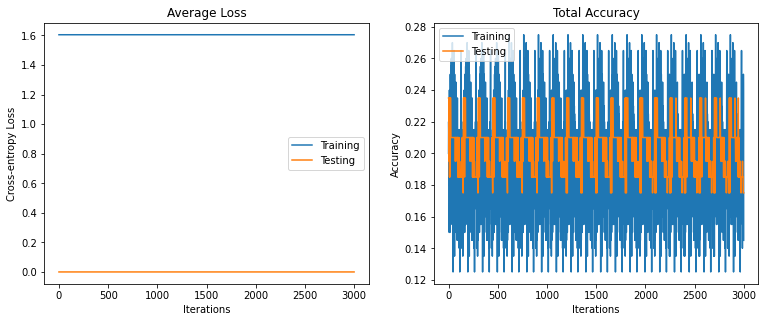

In [ ]:
plot_result(config, train_loss_record, test_loss_record, tolal_training_correct, tolal_testing_correct)

**Ans**:

在zero initialization的情況下，由於weight都是0，model輸出也都是0，可以看到model無法收斂。